<a href="https://colab.research.google.com/github/Jectrianama/GCCE_TEST/blob/main/GoldStanadard/golds_balance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## Principle of relevant information for MA

$$\min_X H(X)+\lambda D_{KL}(X||X_o) = H(X)+\lambda (H(X;X_o) - H(X)))$$

$$\min_X (1-\lambda)H(X)+\lambda H(X;X_o)$$

## Principle of relevant information for RCDNN MA

$$\min_\theta \sum_n \sum_{r\in\Psi_n} (1-\lambda^r_n(\theta))H(\hat{\mathbf{y}}_n(\theta))+\lambda_n^r(\theta)H({\mathbf{y}}^r_n;\hat{\mathbf{y}}_n(\theta))$$

${\mathbf{y}}^r_n\in[0,1]^K$: 1-K label vector for the r-th annotator

$\hat{{\mathbf{y}}}_n\in[0,1]^K$: 1-K label vector for the RCDNN prediction

$\lambda_n^r(\theta)\in[0,1]$: annotator reliability

$\theta$: RCDNN parameters (network weights and bias)

$H(\hat{\mathbf{y}}_n(\theta))= \sum_k \hat{y}_{n,k}\log\left(\hat{y}_{n,k}\right)$: marginal entropy

$H({\mathbf{y}}^r_n;\hat{\mathbf{y}}_n(\theta)) = \sum_k {y}^r_{n,k}\log\left(\hat{y}_{n,k}\right)$: cross-entropy

Then:


$$\min_\theta \sum_n\left(\sum_r \lambda_n^r(\theta)H({\mathbf{y}}^r_n;\hat{\mathbf{y}}_n(\theta))\right)+\left(H(\hat{\mathbf{y}}_n(\theta))\sum_r\left(1-\lambda_n^r(\theta)\right)\right)$$



## Matrix-based computation

$$\min_\theta \text{tr}\left(\mathbf{\Lambda}^\top\mathbf{H}_{y,\hat{y}}\right) + \mathbf{H}_{\hat{y}}^\top(\mathbf{1}_N\mathbf{1}^\top_R-\mathbf{\Lambda})\mathbf{1}_R$$

$\mathbf{1}_N\in\mathbb{R}^{N\times 1}$, $\mathbf{1}_R\in\mathbb{R}^{R\times 1}$

$\mathbf{\Lambda}\in[0,1]^{N\times R}$

$\mathbf{H}_{\hat{y}}\in\mathbb{R}^{N\times 1}$

$\mathbf{H}_{y,\hat{y}}\in\mathbb{R}^{N\times R}$

In [1]:
#!pip install tensorflow==2.7.0
#!pip install scikeras

# Subclassing for GCCE

In [2]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
#tf.random.set_seed(42)
import types
import tempfile
class Keras_MA_GCCE(): #transformer no va
 #Constructor __init__. Special method: identified by a double underscore at either side of their name
 #work in the background
 # initialize data members to the object. lets the class initialize the object’s attributes and serves no other purpose.
    def __init__(self,epochs=100,batch_size=30,R=5, K=2, dropout=0.5, learning_rate=1e-3,optimizer='Adam', 
                  l1_param=0, validation_split=0.3, verbose=1, q = 0.1):
        self.epochs=epochs
        self.dropout=dropout
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l1_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.R=R
        self.K=K
        self.q = q

    
 
    def GCCE_MA_loss(self, y_true, y_pred):
        # print(y_true,y_pred)
       # q = 0.1
        pred = y_pred[:, self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
        ann_ = y_pred[:, :self.R]
        # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

        p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
        temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)

        # p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
        # temp1 = ann_*tf.math.log(p_logreg)  
        # temp2 = (1 - ann_)*tf.math.log(1/K)*tf.reduce_sum(Y_true,axis=1)
        # aux = tf.repeat(tf.reduce_sum(pred*tf.math.log(pred),axis=1,keepdims=True), R, axis = 1)
        # tf.print(tf.shape(aux))
        # print(tf.shape(aux))
        # temp2 = (1 - ann_)*aux*tf.reduce_sum(Y_true,axis=1)
        # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
        # print(tf.reduce_mean(Y_true,axis=1).numpy())
        # Y_true_1 = tf.clip_by_value(Y_true, clip_value_min=1e-9, clip_value_max=1)
        # p_logreg_inv = tf.math.reduce_prod(tf.math.pow(Y_true_1, Y_hat), axis=1)
        # temp2 = (1 - ann_)*tf.math.log(p_logreg_inv) 
        temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
        return tf.math.reduce_sum((temp1 + temp2))

 
    def PRI_MA_loss(self, y_true, y_pred): #,  -> PRI
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 
        #PRI MA
        cce_M = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=-1)
        cce_C = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=1)

      

        #N = tf.cast(y_true.shape[0],dtype=tf.int32)
        N = tf.shape(y_true)[0]
        #Ground truth estimation samples (N) x  Classes(K)
        y_pred_tf = y_pred[:,self.R:] 
        # Annotators reliability prediction: samples (N) x  annotators (R)
        lambda_R_tf = y_pred[:,:self.R] #tf.ones(shape=(N,R)) 
        #Y_true 1 K: samples (N) x  Classes(1-K), annotators (R)
        Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth=self.K,axis=1)  
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(y_pred_tf,-1), self.R, axis = -1) 
        #marginal entropy
        #cce along the K classes -> ypred_tf
        Hm_ = cce_M(y_pred_tf,y_pred_tf)
        #cross entropy
        #cce along the K classes -> Y_hat
        Hc_ = cce_C(Y_true_1K,Y_hat)
        #PRI MA computation
        LH = tf.linalg.matmul(lambda_R_tf,Hc_,transpose_a=True) # \Lambda^\top H_c
        temp1 = tf.linalg.trace(LH) #trace(LH)
        Hm1L = tf.linalg.matmul(tf.ones(shape=(N,self.R))-lambda_R_tf,tf.ones(shape=(self.R,1)))# 1_N 1_R^\top - Lambda
        Hm_t = tf.reshape(Hm_,shape=(N,1))
        temp2 = tf.squeeze(tf.linalg.matmul(Hm_t,Hm1L,transpose_a=True)) # Hm^\top Hm1L
        loss_c = temp1+ temp2 #return loss

        return loss_c

 
    def fit(self, X, Y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        P = X.shape[1]
        if self.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, clipnorm=1.0)
        elif self.optimizer == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate, clipnorm=1.0)
        else:
            opt=self.optimizer

        #capa de entrada
        input_l = tf.keras.layers.Input(shape=(X_train.shape[1]), name='entrada')
        #capas densas
        h1 = tf.keras.layers.Dense(int(P*4*(self.K+self.R)),activation='selu',name='h1',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(input_l)#argumento de entrada
        h2 = tf.keras.layers.Dense(int(P*(self.K+self.R)),activation='selu',name='h2',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(h1)
        dout = tf.keras.layers.Dropout(rate=self.dropout)(h2)
        #capa de salida
        output = tf.keras.layers.Dense(self.K,activation="softmax",name='output',
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(dout)
        self.model = tf.keras.Model(inputs= input_l,outputs=output)
        self.model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt,metrics=['accuracy'])
         
            
 
        self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split=self.validation_split,   #
                                      batch_size=self.batch_size,verbose=self.verbose)
 
        return self
 
  
    
    def predict(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
      return  self.model.predict(X) 
 
 

    def fit_predict(self,X,y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        self.fit(X,y)
        return self.predict(X)
  
     #graphics
    def plot_history(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        #save_fig("keras_learning_curves_plot")
        plt.show()
        return
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self
    
    
    
    def get_params(self, deep=True):
        return { 'l1_param':self.l1_param, 'dropout':self.dropout, 'optimizer':self.optimizer,
                'learning_rate':self.learning_rate, 'batch_size':self.batch_size,
                'epochs':self.epochs, 'verbose':self.verbose, 'validation_split':self.validation_split,
                'R':self.R, 'K':self.K, 'q':self.q
                }

  
        return self


In [3]:
#cargar datos desde drive acceso libre#
#https://drive.google.com/file/d/1sKe2Y8ySCqSjmBprPUUj7zVU5QiicaTV/view?usp=share_link
FILEID = "1sKe2Y8ySCqSjmBprPUUj7zVU5QiicaTV"
#https://drive.google.com/file/d/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O balance-scale.zip && rm -rf /tmp/cookies.txt
!unzip -o balance-scale.zip
!dir

--2023-02-02 20:47:42--  https://docs.google.com/uc?export=download&confirm=&id=1sKe2Y8ySCqSjmBprPUUj7zVU5QiicaTV
Resolving docs.google.com (docs.google.com)... 172.217.203.102, 172.217.203.100, 172.217.203.113, ...
Connecting to docs.google.com (docs.google.com)|172.217.203.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ll1q1tc2bmnt6d8c0gp6cp6uh1jifrc9/1675370850000/07591141114418430227/*/1sKe2Y8ySCqSjmBprPUUj7zVU5QiicaTV?e=download&uuid=dd3510ac-c881-41e3-b0a4-45ab25df1766 [following]
--2023-02-02 20:47:42--  https://doc-0c-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ll1q1tc2bmnt6d8c0gp6cp6uh1jifrc9/1675370850000/07591141114418430227/*/1sKe2Y8ySCqSjmBprPUUj7zVU5QiicaTV?e=download&uuid=dd3510ac-c881-41e3-b0a4-45ab25df1766
Resolving doc-0c-90-docs.googleusercontent.com (doc-0c-90-docs.googleusercontent.com)... 74.125.26.132

# Load Data

In [4]:
#load data
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf #importar tensorflow
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
database = 'Balance' #['bupa1', 'breast-cancer-wisconsin1','pima-indians-diabetes1', 'ionosphere1', 'tic-tac-toe1', 'iris1', 'wine1', 'segmentation1']


import pandas as pd
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv(r'/content/balance-scale.csv') 
df.head()

#Dividing X and y
t = np.array(LabelEncoder().fit_transform(df['Class'].tolist()))
X = np.array(df.drop(['Class'], axis = 1).values)
print('X',X.shape,'t',t.shape)
# t = t+1
# t
    

X (625, 4) t (625,)


In [5]:
 
t

array([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 2, 1, 0, 2, 2, 2, 1, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 1, 1, 2, 2, 2,
       1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 0,
       2, 1, 0, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 0, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 2, 2, 2, 1, 0, 2, 2, 2,
       1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1,
       2, 2, 2, 1, 0, 2, 2, 2, 1, 1, 0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1,
       0, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1,

# Split data

In [6]:
import numpy.matlib
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
Ns = 1
ss = ShuffleSplit(n_splits=Ns, test_size=0.3,random_state =123)
for train_index, test_index in ss.split(X):
    print(test_index)
    X_train, X_test  = X[train_index,:], X[test_index,:] 
    Y_true_train, Y_true_test = t[train_index].reshape(-1,1), t[test_index].reshape(-1,1)
print(X_train.shape,  Y_true_train.shape)

[618 454 423 593 338 404 345 132 150 379  54 386 508 378 242  43 602  11
 237 192 520  48 333 543 209 524  82 102 374 142 177 288 171 298 348 131
 384 246 470 566 138 353 421 491 320 604 474  85 367 477 527 567  57 548
 356 272 164 264 263 481 430 200 437   5 166  35 509 205 156 542 202 120
 243 107   9 620 601  78 560 134 422 574 282  59 328 512  31 199 185 568
 172 285 396 587 482 611 151 155 297 391  66 275 501 406 502 252 274 266
  75 582 383 327  13 600 300 227 310 431 397 162  79 529 335 221 294 614
 349 622 488 231 270 514 350  36 446 381 196 577 416 550  34  33 212 588
 347 118  15 230 159 429 398  93 217 181 556 190 403 116 336 456 452 170
 426 457 368 280  30   0  72 408 277 392 344 234 362  74 511  24 549 273
  64 402 268 226 261 575  55 287]
(437, 4) (437, 1)


# Apply MinMaxScaler

In [7]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Testing the Class 


iteration: 0


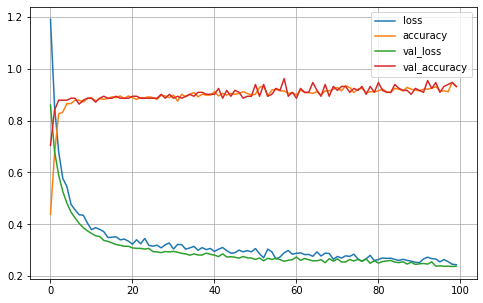

6/6 [==============================] - 0s 2ms/step
Validation ACC: 0.9149
Validation Balanced_ACC: 0.6341
Validation MI: 0.6624
Validation Normalized MI: 0.7503
Validation Adjusted MI: 0.7470
Validation aUc: 0.8208
iteration: 1


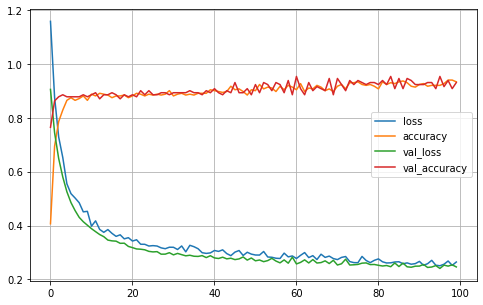

6/6 [==============================] - 0s 3ms/step
Validation ACC: 0.9202
Validation Balanced_ACC: 0.6674
Validation MI: 0.6576
Validation Normalized MI: 0.7449
Validation Adjusted MI: 0.7416
Validation aUc: 0.8405
iteration: 2


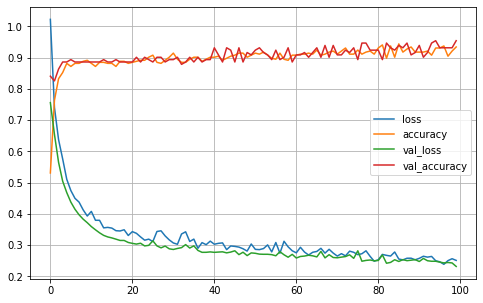

6/6 [==============================] - 0s 2ms/step
Validation ACC: 0.9362
Validation Balanced_ACC: 0.6837
Validation MI: 0.6921
Validation Normalized MI: 0.7953
Validation Adjusted MI: 0.7926
Validation aUc: 0.8514
iteration: 3


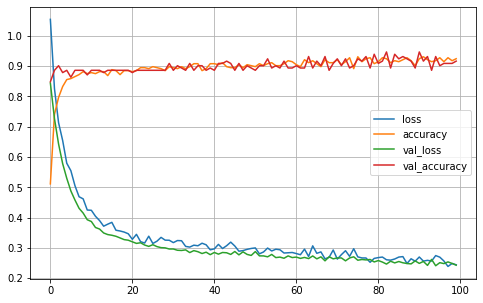

6/6 [==============================] - 0s 2ms/step
Validation ACC: 0.9043
Validation Balanced_ACC: 0.5674
Validation MI: 0.6470
Validation Normalized MI: 0.7439
Validation Adjusted MI: 0.7405
Validation aUc: 0.7873
iteration: 4


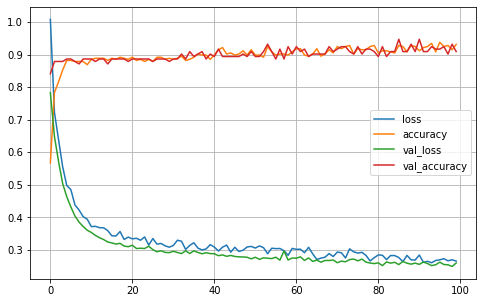

6/6 [==============================] - 0s 2ms/step
Validation ACC: 0.8777
Validation Balanced_ACC: 0.5402
Validation MI: 0.5885
Validation Normalized MI: 0.6679
Validation Adjusted MI: 0.6636
Validation aUc: 0.7699
iteration: 5


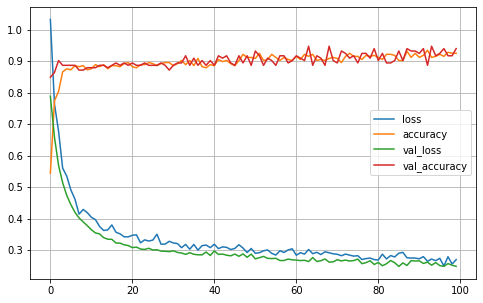

6/6 [==============================] - 0s 3ms/step
Validation ACC: 0.9043
Validation Balanced_ACC: 0.5674
Validation MI: 0.6470
Validation Normalized MI: 0.7439
Validation Adjusted MI: 0.7405
Validation aUc: 0.7873
iteration: 6


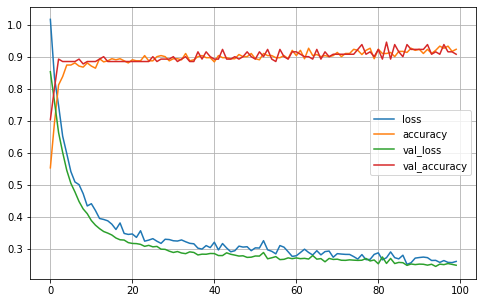

6/6 [==============================] - 0s 4ms/step
Validation ACC: 0.8883
Validation Balanced_ACC: 0.5790
Validation MI: 0.6259
Validation Normalized MI: 0.7005
Validation Adjusted MI: 0.6966
Validation aUc: 0.7869
iteration: 7


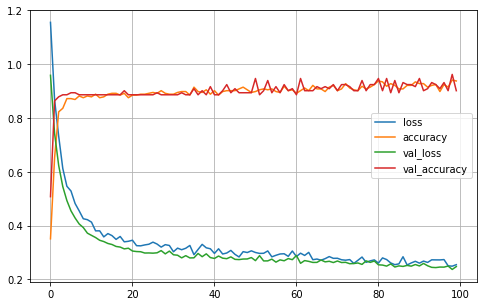

6/6 [==============================] - 0s 3ms/step
Validation ACC: 0.8723
Validation Balanced_ACC: 0.5069
Validation MI: 0.6338
Validation Normalized MI: 0.7097
Validation Adjusted MI: 0.7059
Validation aUc: 0.7435
iteration: 8


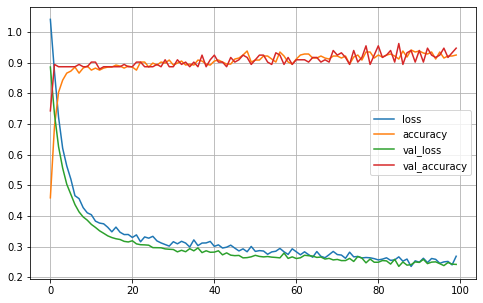

6/6 [==============================] - 0s 2ms/step
Validation ACC: 0.9202
Validation Balanced_ACC: 0.6674
Validation MI: 0.6716
Validation Normalized MI: 0.7555
Validation Adjusted MI: 0.7523
Validation aUc: 0.8376
iteration: 9


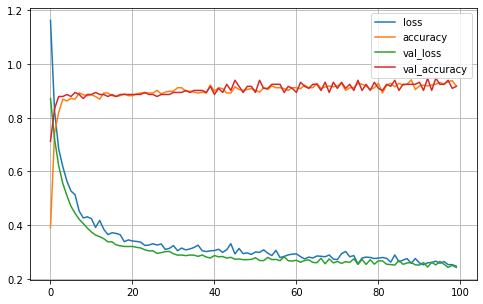

6/6 [==============================] - 0s 3ms/step
Validation ACC: 0.8936
Validation Balanced_ACC: 0.5844
Validation MI: 0.6453
Validation Normalized MI: 0.7218
Validation Adjusted MI: 0.7182
Validation aUc: 0.7890


In [13]:
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
l1 =0.0001
NUM_RUNS =10
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)
for i in range(NUM_RUNS): #10
   
    print("iteration: " + str(i))
    MA = Keras_MA_GCCE(epochs=100,batch_size=32,R=5, K=len(np.unique(Y_true_train)), dropout=0.5, learning_rate=0.001,optimizer='Adam', 
                l1_param=l1,  validation_split=0.30, verbose=0, q=0.1)
    
    MA.fit(X_train, Y_true_train)
    MA.plot_history()
  
    #Accuracy
    pred_2 = MA.predict(X_test)
 
    report = classification_report( pred_2.argmax(axis=1),Y_true_test.ravel(),output_dict=True)
    ACC[i] = report['accuracy']
    print("Validation ACC: %.4f" % (float(ACC[i])))


    # balanced. Accurcy
    BACC[i] = balanced_accuracy_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze(), adjusted=True)
    print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

    #MI
    
    MI[i] = mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    print("Validation MI: %.4f" % (float(MI[i]),))
    NMI[i] = normalized_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
    AMI[i]= adjusted_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))


    #AUC
    val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)  
   # val_logits =MA.predict(X_test) # model(X_test, training=False)
    # tf.print(y_batch_val)
    val_AUC_metric.update_state(Y_true_test, pred_2.argmax(axis=1).astype('float'))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation aUc: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC
    

In [14]:
ACC

array([0.91489362, 0.92021277, 0.93617021, 0.90425532, 0.87765957,
       0.90425532, 0.88829787, 0.87234043, 0.92021277, 0.89361702])

In [15]:

AUC

array([0.82080925, 0.84046245, 0.85144508, 0.78728324, 0.76994222,
       0.78728324, 0.7868979 , 0.74354529, 0.83757222, 0.78901732])

In [16]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)

Average Accuracy:  90.32
Average std:  1.9300000000000002


In [17]:
print('Average Balanced Accuracy: ', np.round( BACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( BACC),4)*100)

Average Balanced Accuracy:  59.98
Average std:  5.680000000000001


In [18]:
print('Average AUC: ', np.round( AUC.mean(),4)*100) 
print('Average AUC std: ',np.round(np.std( AUC),4)*100)

Average AUC:  80.14
Average AUC std:  3.29


In [19]:
print('Average MI: ', np.round( MI.mean(),4)*100) 
print('Average std: ',np.round(np.std(MI),4)*100)

Average MI:  64.71000000000001
Average std:  2.65


In [20]:
print('Average Normalized MI: ', np.round( NMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(NMI),4)*100)

Average Normalized MI:  73.34
Average std:  3.32


In [21]:
print('Average Ajdusted MI: ', np.round( AMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(AMI),4)*100)

Average Ajdusted MI:  72.99
Average std:  3.36
